In [10]:
#79############################################################################
#72#####################################################################
import numpy as np
import pandas as pd
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import plotly.express as px
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [2]:
filepath = ('C:/Users/andre/OneDrive/Desktop/GitHub/Health-AI/'
            'icr-identify-age-related-conditions/')

In [3]:
def balanced_log_loss(y_true, y_pred):
    # This is the old formula. It is wrong.
    y_pred = np.clip(y_pred, 1e-15, 1-1e-15)
    nc = np.bincount(y_true)
    w0, w1 = 1/(nc[0]/y_true.shape[0]), 1/(nc[1]/y_true.shape[0])
    balanced_log_loss_score = (
        -w0/nc[0]
        * (np.sum(np.where(y_true==0,1,0)
        * np.log(1-y_pred))) - w1/nc[1]
        * (np.sum(np.where(y_true!=0,1,0)
        * np.log(y_pred)))
        ) / (w0+w1)
    return balanced_log_loss_score

def competition_log_loss(y_true, y_pred):
    # Updated Formula (actual eval metric)
    # y_true: correct labels 0, 1
    # y_pred: predicted probabilities of class=1
    # Implements the Evaluation equation with w_0 = w_1 = 1.
    # Calculate the number of observations for each class
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    # Calculate the predicted probabilities for each class
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    # Calculate the average log loss for each class
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0)) / N_0
    log_loss_1 = -np.sum(y_true * np.log(p_1)) / N_1
    # return the (not further weighted) average of the averages
    return (log_loss_0 + log_loss_1)/2

In [4]:
train   = pd.read_csv(filepath+'train.csv')
test    = pd.read_csv(filepath+'test.csv')
greeks  = pd.read_csv(filepath+'greeks.csv')
example = pd.read_csv(filepath+'sample_submission.csv')


def solve_whitespace(df):
    # The files have whitespace issues
    renamer={}
    for col in df.columns:
        renamer[col]=col.strip()
    df.rename(columns=renamer,inplace=True)
    return df
train = solve_whitespace(train)
test  = solve_whitespace(test)

In [5]:
# Exploring missing values

train_summary = pd.DataFrame(train[1:].dtypes, columns=['data type'])
train_summary['missing'] = train.isnull().sum().values 
desc = pd.DataFrame(train.describe(include='all').transpose())
train_summary[train_summary['missing']!=0]

,data type,missing
BQ,float64,60
CB,float64,2
CC,float64,3
DU,float64,1
EL,float64,60
FC,float64,1
FL,float64,1
FS,float64,2
GL,float64,1


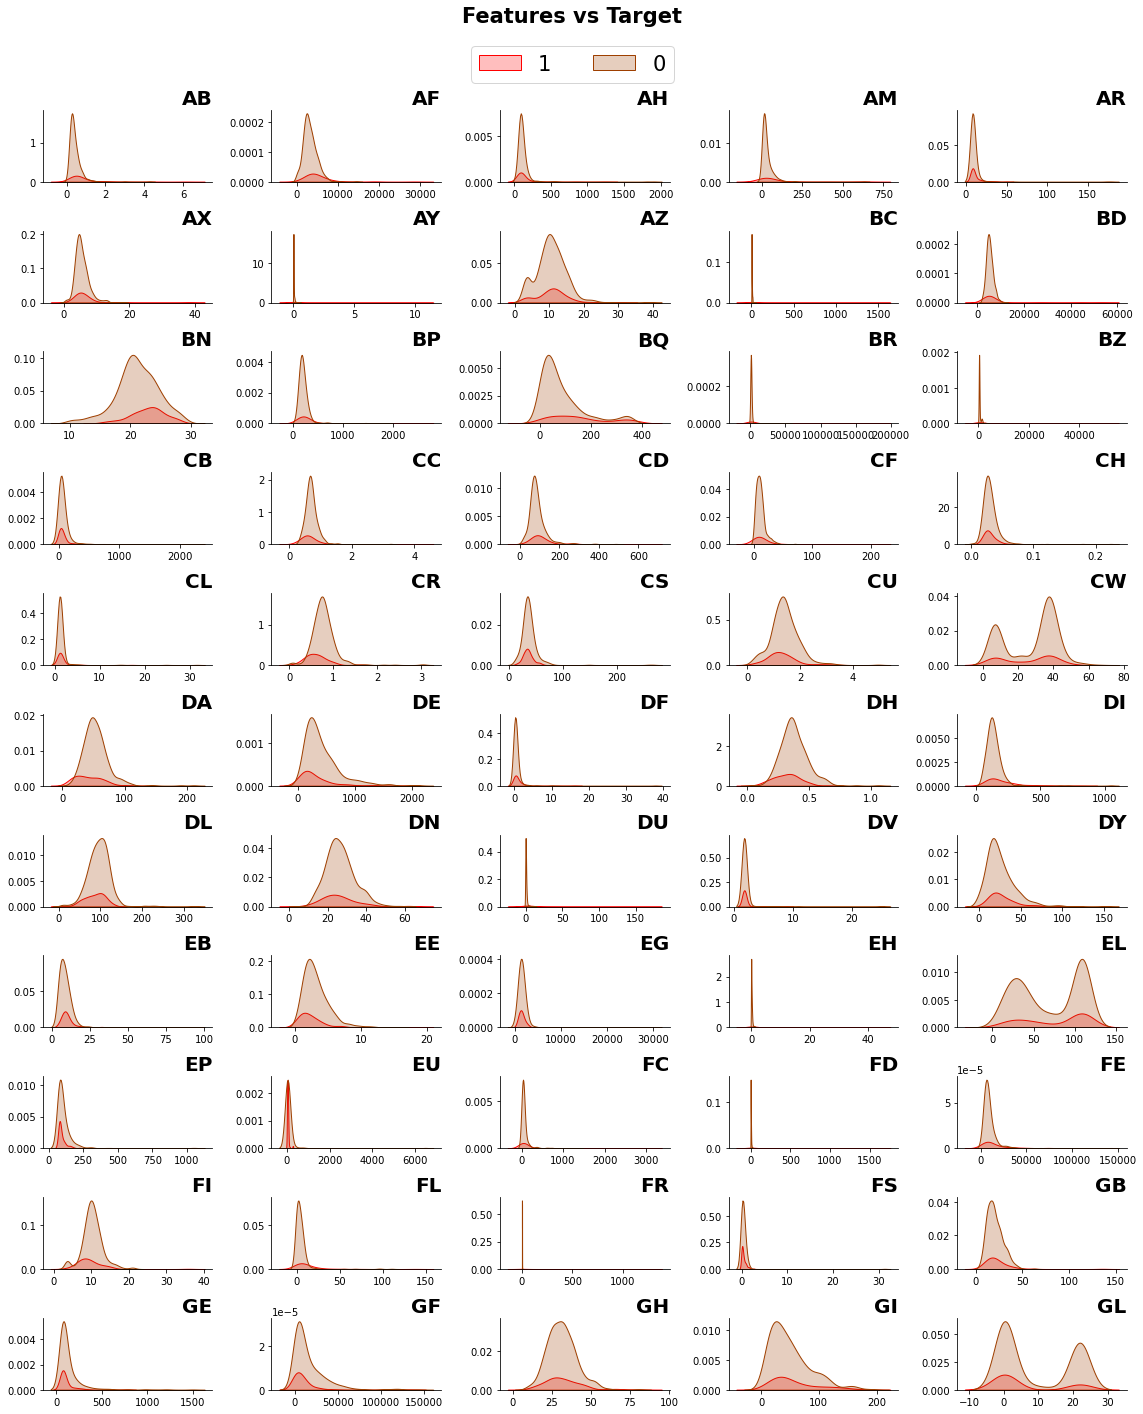

In [11]:
# Distribution of Numerical Vairbles
num_cols = test.select_dtypes(include=['float64']).columns.tolist()
figsize = (4*4, 20)
fig = plt.figure(figsize=figsize)
for idx, col in enumerate(num_cols):
    ax = plt.subplot(11,5, idx + 1)
    sns.kdeplot(
        data=train, hue='Class', fill=True,
        x=col, palette=['#9E3F00', 'red'], legend=False
    )
            
    ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
    ax.set_xlabel(''); ax.spines['right'].set_visible(False)
    ax.set_title(f'{col}', loc='right', 
                 weight='bold', fontsize=20)

fig.suptitle(f'Features vs Target\n\n\n', ha='center',  fontweight='bold', fontsize=21)
fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
plt.tight_layout()
plt.show()

13.038894


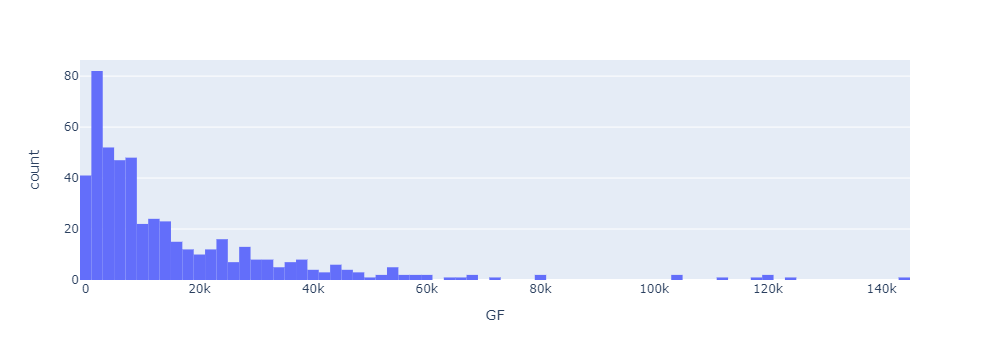

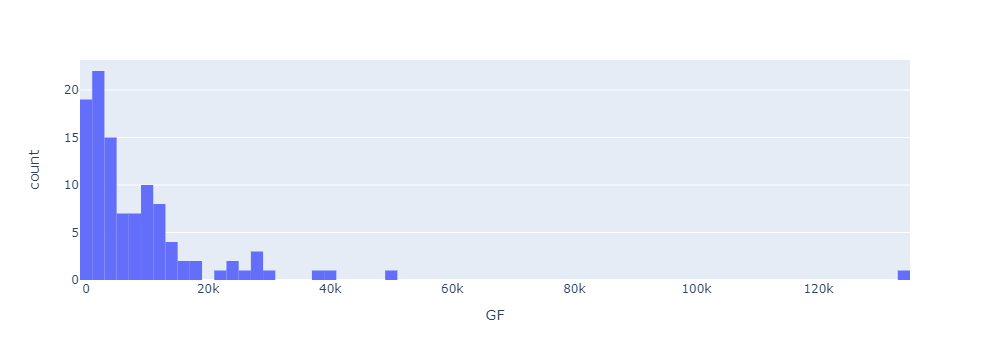

In [56]:
col_of_interest = "GF"
print(train[train['Class']==0][col_of_interest].min())
fig = px.histogram(train[train['Class']==0], x=col_of_interest,nbins=100)
fig.show()
fig = px.histogram(train[train['Class']==1], x=col_of_interest,nbins=100)
fig.show()

In [ ]:
"""
I observe that for a bunch of these variables, it seems like the Class 0
(no diagnosis) is has a smaller standard deviation than the Class 1. This
makes sense given how people with medical conditions will tend to have
more extreme values. I wonder what sort of predictor power I could get
if I simply looked at how far each person strays from the norm.

unimodal_med_good_cols
Let me, for all the unimodal distributions where it appears that Class 1
has less kurtosis than Class 0 (the median seems to be good), calculate
the distance from the Class 0 median and divide it by the class 0
standard deviation.

unimodal_med_bad_cols
This is the opposite from unimodal_med_good_cols. I haven't decided how
to handle this yet.

low_pos_good_cols
For Class 0, these have small positive values. The much higher positive
values are indiciative of Class 1.

other_cols
semi_unimodal_cols
bimodal_cols
These need additional review. I'd especially like to look at all
vairables broken down by the bimodal columns.
"""
unimodal_med_good_cols = [
    "AB",
    "AF",
    "AH",
    "AM",
    "AX",
    "BD",
    "BP",
    "CC",
    "CD",
    "CH",
    "CL",
    "CR",
    "CS",
    "DF",
    "DI",
    "DL",
    "DY",
    "EB",
    "FE",
    "GB",
    "GH",
]
unimodal_med_bad_cols = [
    "EU",
]
other_cols = [
    "AR",
    "CB",
    "CF",
    "DV",
    "EE",
    "EG",
    "EP",
    "FC",
    "FL",
    "FS",
    "GE",
    "GF",
    "GI",
]
low_pos_good_cols = [
    "AY",
    "BC",
    "BR",
    "BZ",
    "DU",
    "EH",
    "FD",
    "FR",
]
semi_unimodal_cols = [
    "AZ",
    "BN",
    "BQ",
    "CU",
    "DA",
    "DE",
    "DH",
    "DN",
    "FI",
]
bimodal_cols = [
    "CW",
    "EL",
    "GL",
]

In [ ]:
def prep_df(df):
    # Move categorical col to beginning of df
    cols = list(df.columns)
    cols.remove('EJ')
    cols.insert(1,'EJ') # Temporarily I will remove this
    df['EJ']=df['EJ'].replace({'A':0,'B':1})
    df=df[cols]
    
    df=df.set_index('Id').copy(deep=True)
    
    """
    7 columns have 1, 2, or 3 null values. If I try to find insights
    from those, I will certainly overfit. I am simply imputing those
    values. Due to my concerns of overfitting due to the tiny dataset,
    I am going to only impute those using the mean/mode. Fancier methods
    risk more overfitting. Columns BQ and EL each have 60 nulls (53 of
    those overlap). For these columns I will create new columns that
    mark them as having had nulls and then impute the missing values.
    """
    df['BQnull'] = 0
    df.loc[df['BQ'].isnull(),'BQnull'] = 1
    df['ELnull'] = 0
    df.loc[df['EL'].isnull(),'ELnull'] = 1
    # Impute values with mean and mode
    for col in df.columns:
        if col in {'Class','Id','BQnull','ELnull'}: continue
        if col=='EJ':
            df[col].fillna(train[col].mode()[0],inplace=True)
        else:
            df[col].fillna(train[col].mean(),inplace=True)
    
    return df
train=prep_df(train)
test=prep_df(test)

#Scale Columns
num_cols = list(train.columns)
num_cols.remove('Class')
sc = StandardScaler()
train[num_cols] = sc.fit_transform(train[num_cols])
test[num_cols]  = sc.transform(test[num_cols])

In [ ]:
fold_count=4



models=[]
test_preds=[]
oof_preds = np.zeros(len(train))

# Separate into input variables and target variable.
x = train.drop(columns='Class').copy(deep=True)
y = train['Class'].copy(deep=True)
del train

weights = class_weight.compute_sample_weight('balanced', y)

skf = StratifiedKFold(n_splits=fold_count, shuffle=True, random_state=42)
for fold, (train_idx, valid_idx) in enumerate(skf.split(x, y)):
    fold_message = 'Fold '+str(fold+1)+' of '+str(fold_count)+' '
    print(fold_message + '-' * (79-len(fold_message)))

    x_train, y_train = x.iloc[train_idx], y.iloc[train_idx]
    x_valid, y_valid = x.iloc[valid_idx], y.iloc[valid_idx]
    
    # Build Model
    model = XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        n_estimators=5000,
        # I am using a scale_pos_weight becuase the evaluation function is a BALANCED log loss
        scale_pos_weight=(len(y[y==0]) / len(y[y==1])),
        random_state=1,
        verbosity=0,
        n_jobs=-1,
        early_stopping_rounds=300,
        learning_rate= 0.005, 
        max_depth=4,
        # alpha=0.000463768723479341,
        # colsample_bytree= 0.618829300507829,
        # min_child_weight=9,
        subsample=0.80,
        eta=0.03,
        gamma=1.5,
        # booster='gbtree',
        # grow_policy='depthwise',
    )
    model.fit(
        x_train,
        y_train,
        eval_set=[(x_valid, y_valid)],
        verbose=0)
    models.append(model)
    
    valid_preds = model.predict_proba(x_valid)[:, 1]
    test_preds.append(model.predict_proba(test)[:, 1])
    
    # Score OOF
    print(
        'Best Iteration:',
        model.best_iteration)
    print(
        'Validation OOF balanced_log_loss (BAD)',
        balanced_log_loss(y_valid, valid_preds))
    print(
        'Validation OOF competition_log_loss (GOOD)',
        competition_log_loss(y_valid, valid_preds))
    print(
        'Validation OOF log_loss with sample_weights',
        log_loss(y_valid, valid_preds, sample_weight=weights[valid_idx]))
    print(
        'Validation OOF log_loss',
          log_loss(y_valid, valid_preds))
    
    oof_preds[valid_idx] = valid_preds
    
test_preds = np.mean(test_preds, axis=0)
x['Pred']=oof_preds
x.sort_index(inplace=True)
y.sort_index(inplace=True)

# Score OOF
print(
    '\n\nCombined OOF balanced_log_loss',
    balanced_log_loss(y, oof_preds))
print(
    'Combined OOF competition_log_loss (GOOD)',
    competition_log_loss(y_valid, valid_preds))
print(
    'Combined OOF log_loss with sample_weights',
    log_loss(y, oof_preds, sample_weight=weights))
print(
    'Combined OOF log_loss',
      log_loss(y, oof_preds))

In [ ]:
#Confusion Matrix for OOF predictions

cm = confusion_matrix(y, x['Pred'].round())

fig = px.imshow(cm,
                text_auto=True,
                labels=dict(x="Predicted", y="Actual", color="Count"),
                x=['0', '1'],
                y=['0', '1']
               )
fig.update_xaxes(side="top")
fig.update_layout(width=500,height=500)

fig.show()




# Feature Importance
for model_pos in range(len(models)):
    model_feature_importance = pd.DataFrame(
        {
            'Value':models[model_pos].feature_importances_,
            'Feature':x.drop(columns='Pred').columns})
    model_feature_importance['Model']=model_pos
    if model_pos==0: feature_importance = model_feature_importance
    else: feature_importance = pd.concat(
        [feature_importance,model_feature_importance],axis=0)

# Sort by total importance across all models
total_feature_importance=feature_importance.groupby('Feature')['Value']
total_feature_importance=total_feature_importance.sum().to_frame().reset_index()

total_feature_importance.rename(
    columns={'Value':'Total Value'},
    inplace=True)
feature_importance=feature_importance.merge(
    total_feature_importance,
    how = 'left',
    on = 'Feature')
# I just want to see top 10 and the special features
feature_importance.sort_values(
    by=["Total Value",'Model'],
    inplace=True)
features_to_plot = feature_importance.drop_duplicates('Feature')
features_to_plot = list(features_to_plot.iloc[-10:]['Feature'].values)
for col in [
    'EJ',
    'BQnull',
    'BQ',
    'ELnull',
    'EL'
    ]:
    if col not in features_to_plot:
        features_to_plot.append(col)
feature_importance=feature_importance[
    feature_importance['Feature'].isin(features_to_plot)]
feature_importance.sort_values(by=["Total Value",'Model'],inplace=True)
feature_importance.rename(columns={'Value':'Importance'},inplace=True)


fig = px.bar(feature_importance, x='Importance', y='Feature', facet_col="Model")
fig.update_layout(width=1000,height=500)
fig.show()

In [ ]:
submission = test.copy(deep=True)
submission['class_1'] = test_preds
submission['class_0'] = [1 - x for x in test_preds]
submission=submission[['class_0','class_1']]

# Save the out of fold predictions on the train dataset
x=x['Pred']

#Save Output
save_output=False

if save_output:
    outputFileName = 'v2'
    outputFileName += (' ' + str(datetime.today())[:22].replace(':','.'))
    x.to_csv(outputFileName + ' ooftrain.csv')
    submission.to_csv(outputFileName + '.csv')

submission.to_csv('submission.csv')
submission